In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
ds_health = pd.read_csv("./Practice data/체질검사.CSV",engine="python")
ds_health.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


# 1. 분석에 필요한 데이터 구성하기

In [50]:
# 목표변수, 설명변수 역할 지정
ds_health_y = ds_health["FAT"]
ds_health_x= ds_health.drop("FAT",axis=1,inplace =False)

print("목표변수 데이터 크기: {}".format(ds_health_y.shape))
print("설명변수 데이터 크기: {}",format(ds_health_x.shape))

목표변수 데이터 크기: (252,)
설명변수 데이터 크기: {} (252, 13)


In [51]:
# 절편 추가
ds_health_x_const = sm.add_constant(ds_health_x)
ds_health_x_const.head()

,const,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,1.0,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,1.0,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,1.0,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,1.0,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,1.0,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


# 2. 변수 간의 경향성 파악 - 그래프 분석

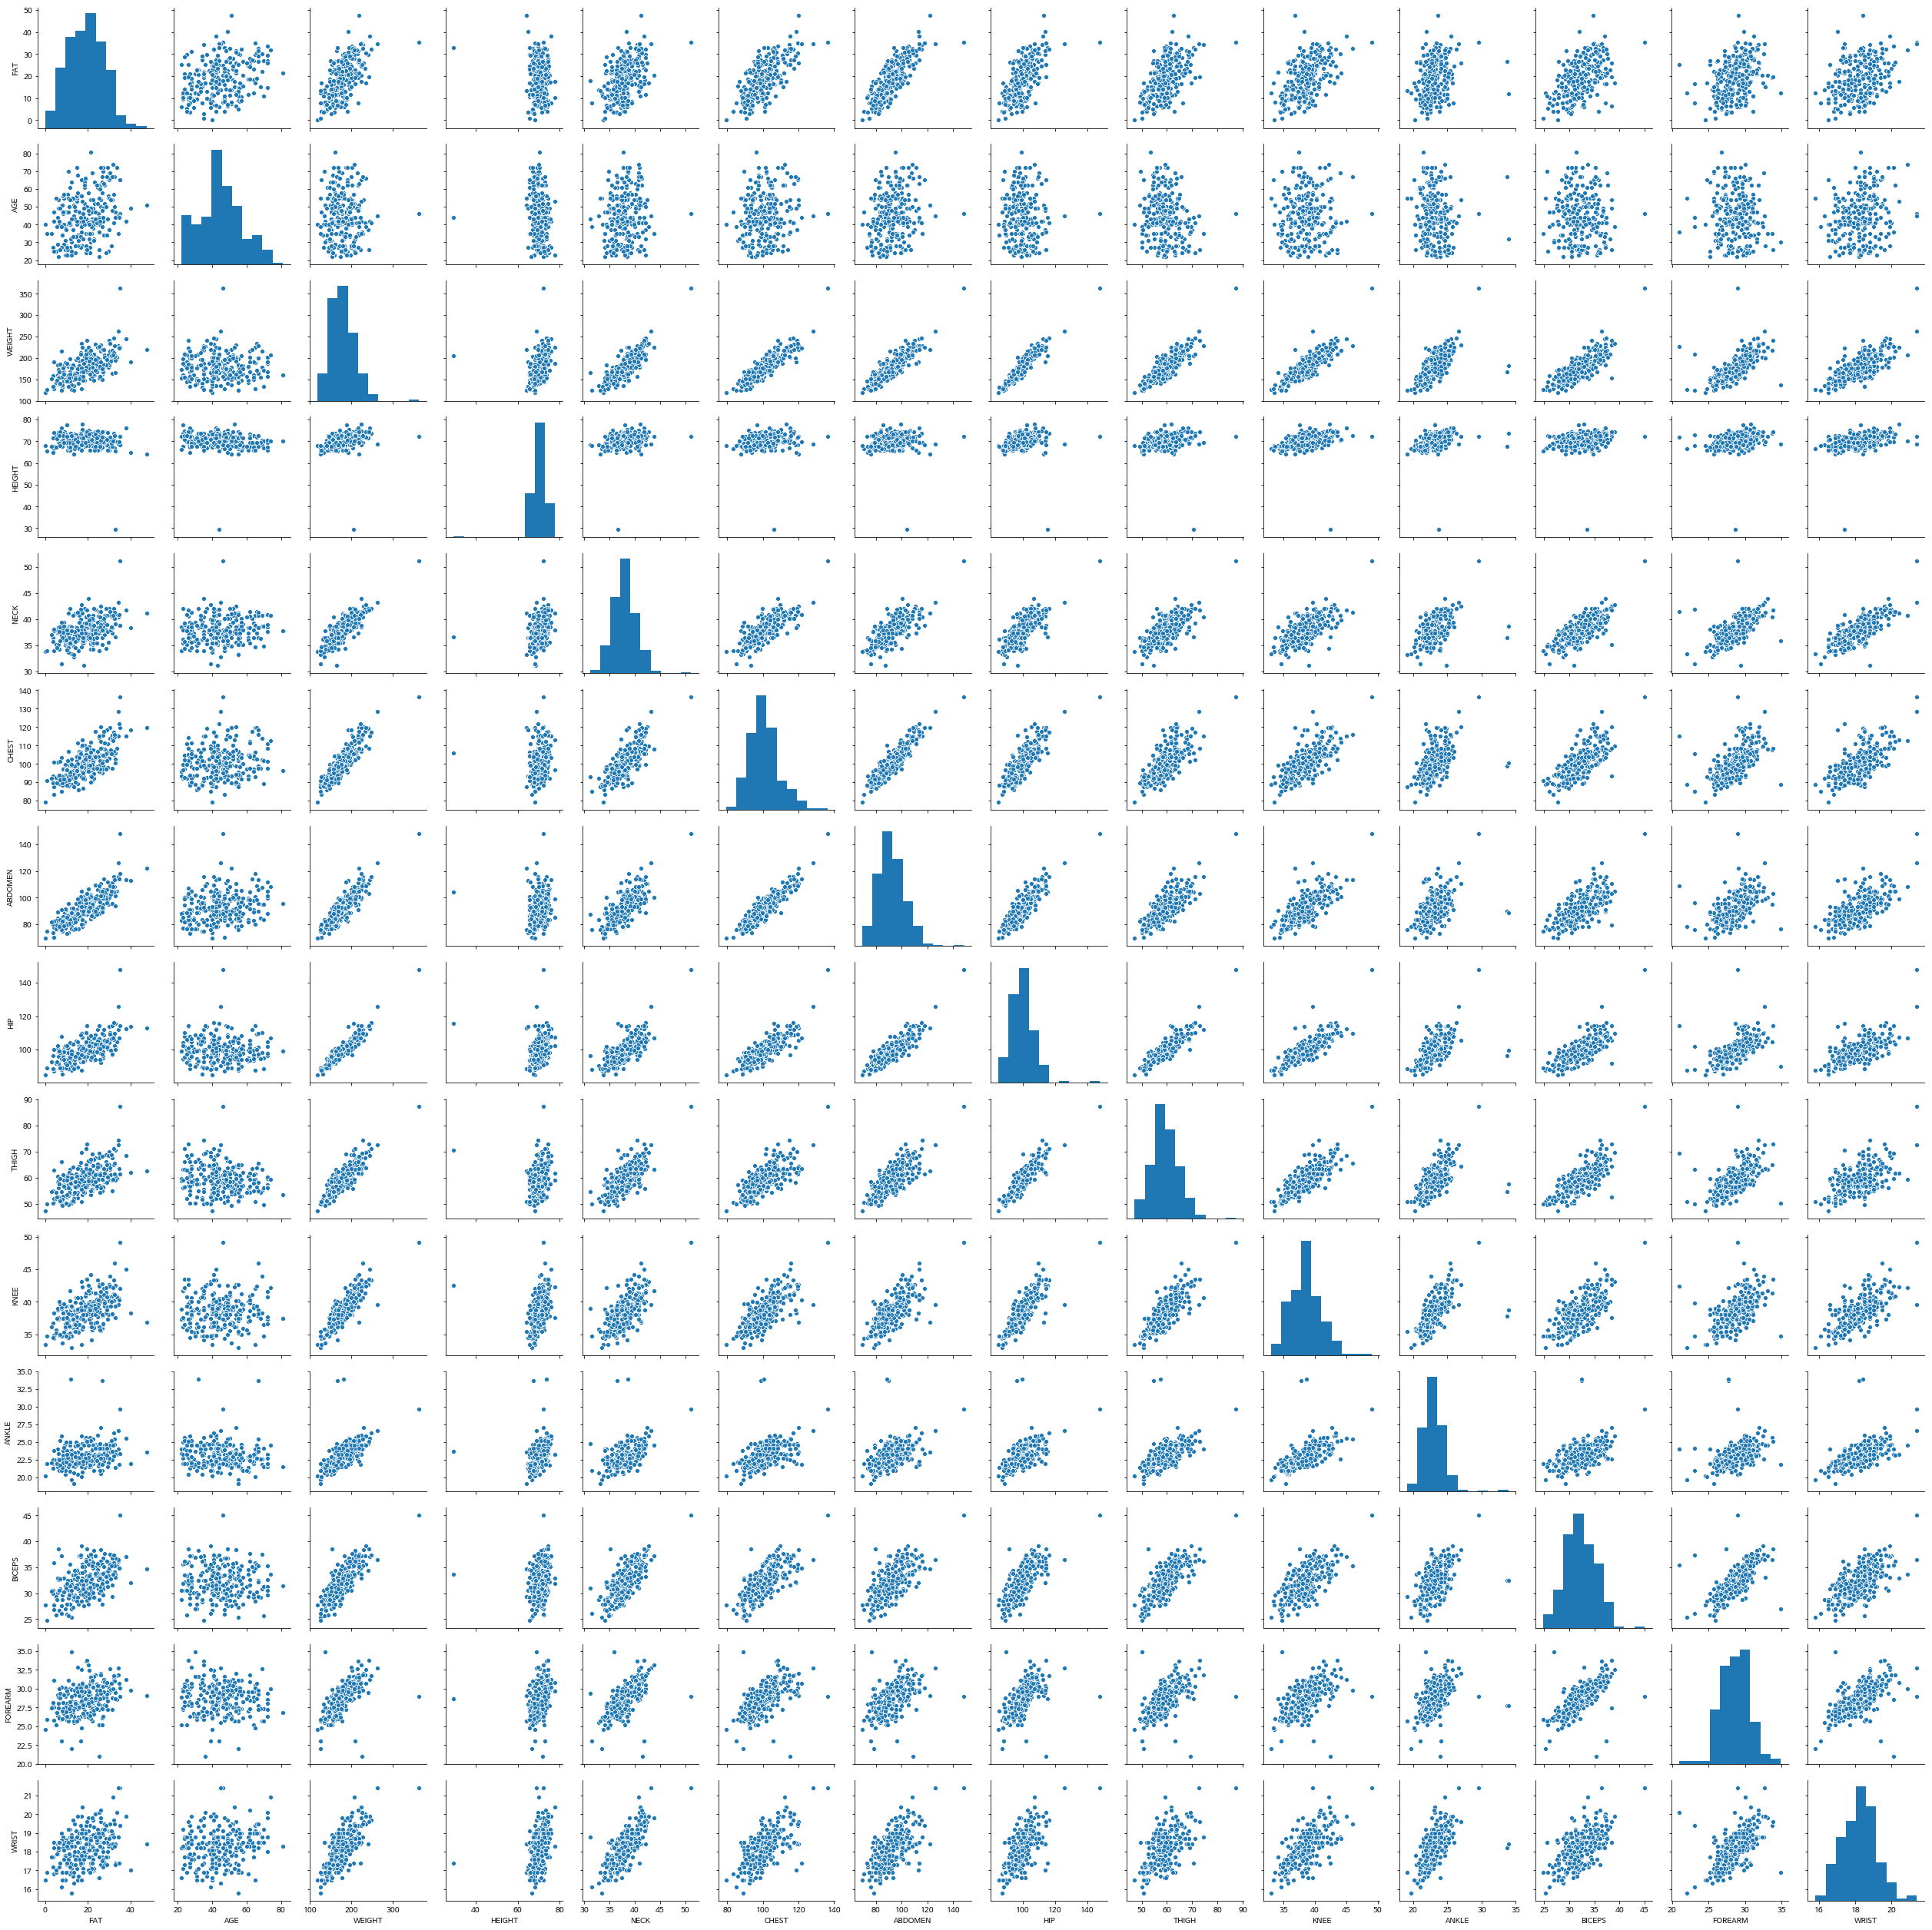

In [22]:
# 산점도 행렬
sns.pairplot(ds_health)

# 3. 변수 간의 경향성 파악 - 상관관계 분석

In [23]:
# 상관 관계 분석
ds_health.corr().round(3)

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
FAT,1.000,0.291,0.612,-0.089,0.491,0.703,0.813,0.625,0.560,0.509,0.266,0.493,0.361,0.347
AGE,0.291,1.000,-0.013,-0.172,0.114,0.176,0.230,-0.050,-0.200,0.018,-0.105,-0.041,-0.085,0.214
WEIGHT,0.612,-0.013,1.000,0.308,0.831,0.894,0.888,0.941,0.869,0.853,0.614,0.800,0.630,0.730
HEIGHT,-0.089,-0.172,0.308,1.000,0.254,0.135,0.088,0.170,0.148,0.286,0.265,0.208,0.229,0.322
NECK,0.491,0.114,0.831,0.254,1.000,0.785,0.754,0.735,0.696,0.672,0.478,0.731,0.624,0.745
CHEST,0.703,0.176,0.894,0.135,0.785,1.000,0.916,0.829,0.730,0.719,0.483,0.728,0.580,0.660
ABDOMEN,0.813,0.230,0.888,0.088,0.754,0.916,1.000,0.874,0.767,0.737,0.453,0.685,0.503,0.620
HIP,0.625,-0.050,0.941,0.170,0.735,0.829,0.874,1.000,0.896,0.823,0.558,0.739,0.545,0.630
THIGH,0.560,-0.200,0.869,0.148,0.696,0.730,0.767,0.896,1.000,0.799,0.540,0.761,0.567,0.559
KNEE,0.509,0.018,0.853,0.286,0.672,0.719,0.737,0.823,0.799,1.000,0.612,0.679,0.556,0.665


# !! 전체 모형에 대한 평판을 알아보는 것 !!
# 1. No. Observations(분석 자료 수 : 252)
 Df Residuals(전체 자유도) : 238 = 252-13-1 잔차 자유도 (뜻은 없고, 자유도의 나머지라고 생각하자)<br>
 **Df Model (모델 자유도) : 13**

ex) 
df(전체) = n -1 = 251<br>
df(모델) = k -1 = 14 -1 = 13 (상수 포함 (add_constant를 했을 경우) 즉 **변수개수 - 1** 이라 생각하자)<br>
dif(error) = n - k - 1

# 2. ANOVA 분석결과 (F-statistic)
 -> p값이 유의수준 0.05보다 작으므로 회귀모델로서 유의

# 3. 설명력 (R-squared)
 -> 모델을 통해 설명변수 EVAL을 74.9% 설명할 수 있음

# 4. 회귀계수 검정 (P>|t|)
 -> 절편의 p값이 유의수준 0.05보다 크므로 계수로서 유의하지 않음 <br>**(회귀 모델에서 절편은 유의하지 않더라도 모델에 포함)**<br>
 ->ABDOMEN의 p값이 유의수준 0.05보다 작으므로 계수로서 유의<br>
 -> WRIST의 p값이 유의수준 0.05보다 작으므로 계수로서 유의<br>
1. **가장 기본적인 해석 모델입니다.**<br>
2. **coef는 회귀계수를 뜻합니다. 회귀계수의 값이 적절한지 검정을 하기 위해서는 t값을 통해 검정해야합니다.**<br>
3.  **t값을 검정하기 위해서는 p-value를 통해 알 수 있습니다.**<br>
4.  **p-value가 0.05보다 크면 귀무가설을 채택합니다.**<br>
5. **이 때 귀무가설은 βi =0 이다입니다.**<br>
6. **p-value가 0.05보다 크면 βi = 0 이고, 이 의미는 기울기가 0을 의미합니다.**<br>
7. **그 결과 계수의 값을 믿을 수 없다라고 결론을 내릴 수 있습니다.**<br>

ex) ABDOMEN은 신뢰할수 있고, CHEST는 신뢰할수 없겠죠.

In [24]:
# 회귀 모델 생성
reg_multi_model = sm.OLS(ds_health_y, ds_health_x_const)
# 적합
reg_multi_results = reg_multi_model.fit()
print(reg_multi_results.summary())
# std err = 표준오차 (조사해보기)

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     54.65
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           7.72e-64
Time:                        14:18:27   Log-Likelihood:                -718.25
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     238   BIC:                             1514.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.1885     17.349     -1.048      0.2

# 3. 회귀 모델 생성 : 전체 설명변수 대상으로 다중 공선성 검토

1. 다중공선성이 WEIGHT가 가장 큰 것을 확인

In [25]:
# 데이터 테이블 생성 -> 값 입력
ds_vif = pd.DataFrame()
# 변수 명 입력
ds_vif["variable"] = ds_health_x_const.columns
# variance_inflation_factor 다중공선성 함수, exog : 설명변수 데이터, exog_idx : 변수 인덱스
ds_vif["vif"] = [variance_inflation_factor(ds_health_x_const.values,i) for i in range(ds_health_x_const.shape[1])]
# VIF 낮은 순 정렬
ds_vif.sort_values("vif",inplace = True)
ds_vif.round(3)

,variable,vif
3,HEIGHT,1.675
10,ANKLE,1.908
12,FOREARM,2.192
1,AGE,2.250
13,WRIST,3.378
11,BICEPS,3.620
4,NECK,4.324
9,KNEE,4.612
8,THIGH,7.778
5,CHEST,9.461


# 4. 후진제거법을 이용한 변수 선택
1. 작은 variables변수 선택

In [52]:
# RFE(recursive feature elimination) 함수: 입력된 모델을 이용해 변수중요도가 낮은 순으로 순차적 제거
# sklearn의 선형회귀 모델
model = LinearRegression()
# 전체의 변수 중 5개의 변수가 남을 때까지 변수 제거
rfe = RFE(estimator = model, n_features_to_select = 5).fit(ds_health_x,ds_health_y)
# 선택된 변수
selected_cols = ds_health_x.columns[rfe.support_]
# 제거된 변수
removed_cosl = ds_health_x.columns[~rfe.support_]

print("Selected Variables : {}".format(selected_cols))
print("Removed Variables : {}".format(removed_cosl))

Selected Variables : Index(['NECK', 'ABDOMEN', 'HIP', 'FOREARM', 'WRIST'], dtype='object')
Removed Variables : Index(['AGE', 'WEIGHT', 'HEIGHT', 'CHEST', 'THIGH', 'KNEE', 'ANKLE', 'BICEPS'], dtype='object')


# 4.후진제거법을 이용한 변수 선택 - 회귀 모델 선택
# !! 전체 모형에 대한 평판을 알아보는 것 !!
# 1. No. Observations(분석 자료 수 : 252)
 Df Residuals(전체 자유도) : 246 = 252-5-1 잔차 자유도 (뜻은 없고, 자유도의 나머지라고 생각하자)<br>
 **Df Model (모델 자유도) : 5**

# 2. ANOVA 분석결과 (F-statistic)
 -> p값이 유의수준 0.05보다 작으므로 회귀모델로서 유의

# 3. 설명력 (R-squared)
 -> 모델을 통해 설명변수 EVAL을 73.1% 설명할 수 있음

# 4. 회귀계수 검정 (P>|t|)
 -> 절편의 p값이 유의수준 0.05보다 크므로 계수로서 유의하지 않음 <br>**(회귀 모델에서 절편은 유의하지 않더라도 모델에 포함)**<br>
 ->ABDOMEN의 p값이 유의수준 0.05보다 작으므로 계수로서 유의<br>|
 -> WRIST의 p값이 유의수준 0.05보다 작으므로 계수로서 유의<br>

In [27]:
# 후진제거법에의해 선택된 데이터
ds_health_x_rfe = sm.add_constant(ds_health_x_const[selected_cols])
# 회귀 모델 생성
reg_multi_rfe_model = sm.OLS(ds_health_y, ds_health_x_rfe)
# 적합
reg_multi_rfe_results = reg_multi_rfe_model.fit()
print(reg_multi_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     54.65
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           7.72e-64
Time:                        14:18:27   Log-Likelihood:                -718.25
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     238   BIC:                             1514.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.1885     17.349     -1.048      0.2

# 4. 후진제거법을 이용한 변수 선택 - 선정된 설명변수 대상으로 다중 공선성 진단
1. **변수 제거법을 이용해 선택된 변수들 간에는 다중공선성의 문제 없음** <br>

In [46]:
# 후진제거법에 의해 선택된 데이터
ds_rfe_vif = pd.DataFrame()
ds_rfe_vif["variable"] = ds_health_x_rfe.columns
ds_rfe_vif["vif"] = [variance_inflation_factor(ds_health_x_rfe.values,i)for i in range(ds_health_x_rfe.shape[1])]
ds_rfe_vif.sort_values("vif",inplace = True)
ds_rfe_vif.round(3)
reg_multi_rfe_results = ds_rfe_vif

# Part 2
# VIF를 분석해보니 WEIGHT의 VIF가 가장커 빼고 분석해보자!!

# 1. 분석에 필요한 데이터구성 - FAT, WEIGHT 제거
 - 그래프를 보면 FAT, WEIGHT이 빠져있는 것을 확인

In [29]:
ds_health_y = ds_health["FAT"]
ds_health_x = ds_health.drop(["FAT","WEIGHT"], axis =1, inplace = False)
ds_health_x.head()
print("목표변수 데이터 크기: {}".format(ds_health_y.shape))
print("설명변수 데이터 크기: {}",format(ds_health_x.shape))

목표변수 데이터 크기: (252,)
설명변수 데이터 크기: {} (252, 12)


# 1. 분석에 필요한 데이터구성 - const 항목 추가 

In [30]:
# 절편 추가
ds_health_x_const = sm.add_constant(ds_health_x)
ds_health_x_const.head()
# const 항목 추가 

,const,AGE,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,1.0,46,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,1.0,27,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,1.0,69,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,1.0,57,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,1.0,51,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [61]:
# 다시 Regression
reg_multi_model = sm.OLS(ds_health_y, ds_health_x_const)
reg_multi_results = reg_multi_model.fit()
print(reg_multi_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.735
Method:                 Least Squares   F-statistic:                     54.65
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           7.72e-64
Time:                        14:47:05   Log-Likelihood:                -718.25
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     238   BIC:                             1514.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.1885     17.349     -1.048      0.2

# 다시 다중공선성 살펴보기

In [62]:
ds_vif = pd.DataFrame()
ds_vif["variable"] = ds_health_x_const.columns
ds_vif["VIF"] = [variance_inflation_factor(ds_health_x_const.values,i) for i in range(ds_health_x_const.shape[1])]

ds_vif.sort_values("VIF",inplace =True)
ds_vif.round(3)

,variable,VIF
3,HEIGHT,1.675
10,ANKLE,1.908
12,FOREARM,2.192
1,AGE,2.250
13,WRIST,3.378
11,BICEPS,3.620
4,NECK,4.324
9,KNEE,4.612
8,THIGH,7.778
5,CHEST,9.461


In [33]:
# 회귀 모델 생성
reg_multi_model2 = sm.OLS(ds_health_y, ds_health_x_constant2)
# 적합
reg_multi_results2 = reg_multi_model2.fit()
print(reg_multi_results2.summary())
# std err = 표준오차 (조사해보기)

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     58.55
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           3.75e-64
Time:                        14:18:45   Log-Likelihood:                -719.69
No. Observations:                 252   AIC:                             1465.
Df Residuals:                     239   BIC:                             1511.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.5453      7.672      0.984      0.3

In [63]:
ds_vif = pd.DataFrame()
ds_vif["variable"] = ds_health_x_const.columns
ds_vif["VIF"] = [variance_inflation_factor(ds_health_x_const.values,i) for i in range(ds_health_x_const.shape[1])]

ds_vif.sort_values("VIF",inplace =True)
ds_vif.round(3)

,variable,VIF
3,HEIGHT,1.675
10,ANKLE,1.908
12,FOREARM,2.192
1,AGE,2.250
13,WRIST,3.378
11,BICEPS,3.620
4,NECK,4.324
9,KNEE,4.612
8,THIGH,7.778
5,CHEST,9.461


In [64]:
ds_health_y = ds_health["FAT"]
ds_health_x = ds_health.drop(["FAT","WEIGHT","HIP"], axis =1, inplace = False)
ds_health_x.head()

ds_health_x_const = sm.add_constant(ds_health_x)
ds_health_x_const.head()

reg_multi_model = sm.OLS(ds_health_y, ds_health_x_const)
reg_multi_results = reg_multi_model.fit()
print(reg_multi_results.summary())

ds_vif = pd.DataFrame()
ds_vif["variable"] = ds_health_x_const.columns
ds_vif["VIF"] = [variance_inflation_factor(ds_health_x_const.values,i) for i in range(ds_health_x_const.shape[1])]

ds_vif.sort_values("VIF",inplace =True)
print(ds_vif.round(3))

#HIP을 빼는것을 별로 추천 하지 않는다. 어짜피 이젠 R도 잘 오르지 않기 때문이다.

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     61.51
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           1.80e-63
Time:                        14:47:51   Log-Likelihood:                -723.60
No. Observations:                 252   AIC:                             1471.
Df Residuals:                     240   BIC:                             1514.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8402      7.370      0.114      0.9

In [65]:
# 후진제거법에의해 선택된 데이터
model = LinearRegression()
rfe= RFE(estimator = model,n_features_to_select = 5).fit(ds_health_x,ds_health_y)
selected_cols = ds_health_x.columns[rfe.support_]
removed_cosl = ds_health_x.columns[~rfe.support_]
print("Selected Variables : {}".format(selected_cols))
print("Removed Variables : {}".format(removed_cosl))

Selected Variables : Index(['NECK', 'ABDOMEN', 'KNEE', 'FOREARM', 'WRIST'], dtype='object')
Removed Variables : Index(['AGE', 'HEIGHT', 'CHEST', 'THIGH', 'ANKLE', 'BICEPS'], dtype='object')


In [66]:
ds_health_x_rfe= sm.add_constant(ds_health_x_const[selected_cols])

reg_multi_rfe_model = sm.OLS(ds_health_y, ds_health_x_rfe)

reg_multi_rfe_results = reg_multi_rfe_model.fit()
print(reg_multi_rfe_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     125.4
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           1.40e-65
Time:                        14:48:09   Log-Likelihood:                -732.86
No. Observations:                 252   AIC:                             1478.
Df Residuals:                     246   BIC:                             1499.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5780      6.256     -0.412      0.6

In [67]:
ds_rfe_vif = pd.DataFrame()
ds_rfe_vif["variable"] = ds_health_x_rfe.columns
ds_rfe_vif["VIF"] = [variance_inflation_factor(ds_health_x_rfe.values,i) for i in range(ds_health_x_rfe.shape[1])]
ds_rfe_vif.sort_values("VIF",inplace = True)
ds_rfe_vif.round(3)

,variable,VIF
4,FOREARM,1.788
5,WRIST,2.597
3,KNEE,2.683
2,ABDOMEN,2.998
1,NECK,3.534
0,const,489.747


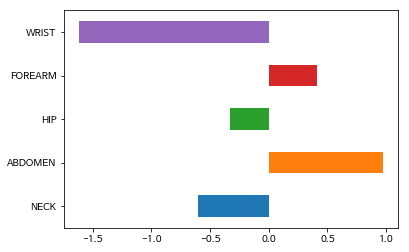

In [60]:
# 표준화 회귀계수가 필요하면 표준화를 먼저 하면된다.
# 데이터 펴준화, 평균 0 표준편차 1
ds_health_x_scaled = scale(ds_health_x_constant2[selected_cols2])
# 후진제거법에 의해 선택된 데이터에 상수 1 입력
ds_health_x_scaled=sm.add_constant(ds_health_x_scaled)
#  회귀 모델 생성
reg_multi_rfe_model2 = sm.OLS(ds_health_y,ds_health_x_scaled)
# 적합
reg_multi_scaled_results = reg_multi_rfe_model2.fit()
# 설명변수 중요도
ds_reg_scaled_coef = pd.DataFrame({"Coef" : reg_multi_scaled_results.params.values[1:]},index=reg_multi_rfe_model2.exog_names[1:])
ds_reg_coef.plot.barh(y="Coef",legend=False)

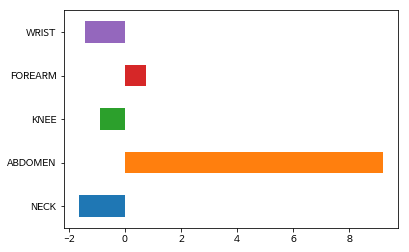

In [69]:
ds_health_x_scaled = scale(ds_health_x_const[selected_cols])
ds_health_x_scaled = sm.add_constant(ds_health_x_scaled)
reg_multi_scaled_model = sm.OLS(ds_health_y, ds_health_x_scaled)
reg_multi_scaled_results = reg_multi_scaled_model.fit()
ds_reg_scaled_coef = pd.DataFrame({"Coef":reg_multi_scaled_results.params.values[1:]}, index = reg_multi_rfe_model.exog_names[1:])
ds_reg_scaled_coef.plot.barh(y = "Coef",legend = False)

In [70]:
import statsmodels.formula.api as smf
formula_model = smf.ols(formula = "FAT~NECK + ABDOMEN + FOREARM + WRIST ",data = ds_health)
formula_result = formula_model.fit()
print(formula_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     154.1
Date:                Wed, 30 Jan 2019   Prob (F-statistic):           6.80e-66
Time:                        14:48:38   Log-Likelihood:                -734.77
No. Observations:                 252   AIC:                             1480.
Df Residuals:                     247   BIC:                             1497.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.4679      5.959     -1.085      0.2